In [3]:
import os
import math
import scipy
from typing import List, Union, Tuple, Sequence
import sys

import pyvista
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from pint import Quantity
from scipy.optimize import curve_fit

import cv2, h5py
from pathlib import Path
import tensorflow as tf
gpu = tf.config.get_visible_devices("GPU")[0]
tf.config.set_visible_devices(gpu, device_type="GPU")
tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
# import cmr_rnd_diffusion
sys.path.insert(0, "../..")
sys.path.insert(0, "../../../cmrseq/")
import cmrsim
import cmrseq

ModuleNotFoundError: No module named 'cmrseq'

In [ ]:
# The raster times here, directly influence the bloch-simulation step-width
system_specs = cmrseq.SystemSpec(gamma=Quantity(42.576, 'MHz / T'),
                                 max_grad=Quantity(40, "mT/m"),
                                 max_slew=Quantity(200, "mT/m/ms"),
                                 grad_raster_time=Quantity(10, "us"),
                                 rf_raster_time=Quantity(10, "us")
                                )

## Set up cardiac mesh 

In [79]:
# Cardiac mesh implementation goes here
fn = "refined_mesh_(121,150,16).vtk"
mesh_numbers = [int(s) for s in fn.replace("refined_mesh_(", "").replace(").vtk", "").split(",")]
refined_mod = cmr_rnd_diffusion.CardiacMeshDataset.from_single_vtk(fn, time_precision_ms=3, mesh_numbers=mesh_numbers)
refined_mod.mesh.translate((-0.026, 0, 0.010))
refined_mod.mesh.opacity=0.5
triggerDelay = 200

NameError: name 'cmr_rnd_diffusion' is not defined

In [ ]:
# Select slice according to the following slice parameters:
slice_dict = dict(slice_thickness=Quantity(40, "mm"),
                  slice_normal=np.array((0., 0., 1.)),
                  slice_position=Quantity([0, 0, 0], "cm"),
                  reference_time=Quantity(triggerDelay, "ms"))

slice_mesh = refined_mod.select_slice(**slice_dict)
slice_mod =  cmr_rnd_diffusion.BaseDataset(slice_mesh, refined_mod.timing)

# Now get actual time / positional values for all points contained in the mesh:
t, r = slice_mod.get_trajectories(start=slice_dict["reference_time"],
                                  end=Quantity(triggerDelay+50, "ms"))

print(f"Temporal reference grid: {t.shape}[{t.units}]", 
      f"Positions at reference times: {r.shape} [{r.units}]")

In [ ]:
trajectory_mod = cmrsim.trajectory.TaylorTrajectoryN(order=6, time_grid=(t-t[0]).m_as("ms"),particle_trajectories=r)

In [ ]:
from cmrsim.utils import particle_properties as part_factory
# Define new time-grid
new_tgrid = tf.range(0, 10, 2, dtype=tf.float32)

# Call the module to get all new positions. Note, the second returned dict is useless in our case.
new_positions, _ = trajectory_mod(new_tgrid)

print(f"Time grid: {new_tgrid.shape},  Positions: {new_positions.shape}")

# Animate the mesh motion with new positions:
new_positions = np.array(new_positions)  # necessary for plotting below
cp_mesh = slice_mod.mesh.copy()
pyvista.close_all()
pyvista.start_xvfb()
plotter = pyvista.Plotter(off_screen=True, window_size=(800, 800))
# plotter.add_mesh(cp_mesh,opacity=1)
# plotter.add_mesh(voxel,opacity=1)
plotter.open_gif(f"TaylorTrajectory.gif")
for step in tqdm(range(0, len(new_tgrid)), desc="Redering Mesh-Animation"):
    text_actor = plotter.add_text(f"{new_tgrid[step]: 1.0f} ms", position='upper_right', color='grey', 
                                  shadow=False, font_size=26, render=False)    
    plotter.update_coordinates(new_positions[:, step], mesh=cp_mesh, render=False)
    plotter.render()
    plotter.write_frame()
    plotter.remove_actor(text_actor)
plotter.close()

## Pulse sequence definition

In [ ]:
%run _sequence_def.py

In [ ]:
time_raster, rf_raster, wf_raster, adc_raster = grid_out = [np.stack(v) for v in cmrseq.utils.grid_sequence_list(sequence_list=[seq, ], force_uniform_grid=False)]
print("Waveforms on raster: \n\t", "\n\t".join([f"{name:<15}: {v.shape}  | {v.dtype}" 
                                                for name, v in zip("time_raster,rf_raster,wf_raster,adc_raster".split(","), grid_out)]))


## Simulate pulse sequence

In [ ]:
from cmrsim.utils import particle_properties as part_factory

initial_positions, _ = trajectory_mod(tf.constant([0.,], dtype=tf.float32))  # is already in meter
n_particles = initial_positions.shape[0]

phantom_dict = {
    "M0":  tf.ones(n_particles),         # Used for scaling. If constant --> all particle are weighted the same for summation
    "T1":  tf.random.normal(shape=(n_particles,), mean=1000, stddev=100),  # in millisecond
    "T2":  tf.random.normal(shape=(n_particles, ), mean=80, stddev=5),   # in millisecond
    "magnetization": part_factory.norm_magnetization()(n_particles),   # constructs complex magnetization vector for each particle
    "initial_position": tf.reshape(initial_positions, [-1, 3])
}

dataset = cmrsim.datasets.BlochDataset(phantom_dict, filter_inputs=False)

t, r = slice_mod.get_trajectories(start=slice_dict["reference_time"],
                                  end=Quantity(slice_mod.timing[-1], "ms"))
trajectory_mod = cmrsim.trajectory.TaylorTrajectoryN(order=6, time_grid=(t-t[0]).m_as("ms"),
                                                     particle_trajectories=r, batch_size=int(1e6))
rout, _ = trajectory_mod.increment_particles(r=r, dt=0.01)
rout;

### Analytic signal model

In [ ]:
%run _hyperpolarization.py

### Data mask

In [15]:
from scipy import io
mat = io.loadmat('../myoMask.mat')
myoMask = mat['myocardium']
from scipy import ndimage
X,Y = 200, 200
myoMask_ds = np.zeros((X,Y,3))
myoMask_ds[:,:,0] = ndimage.zoom(myoMask[:,:,0],X/220,order=0) #decimate resolution
myoMask_ds[:,:,1] = ndimage.zoom(myoMask[:,:,1],X/220,order=0) #decimate resolution
myoMask_ds[:,:,2] = ndimage.zoom(myoMask[:,:,2],X/220,order=0) #decimate resolution


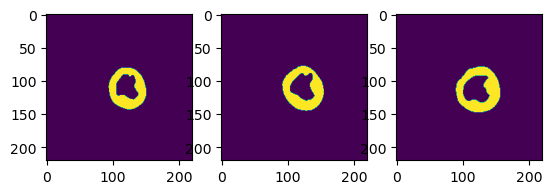

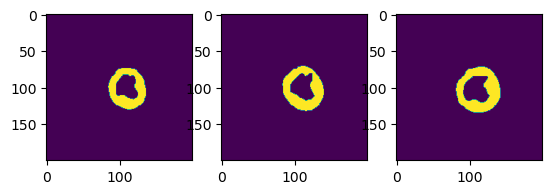

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(myoMask[:,:,0])
ax2.imshow(myoMask[:,:,1])
ax3.imshow(myoMask[:,:,2])
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(myoMask_ds[:,:,0])
ax2.imshow(myoMask_ds[:,:,1])
ax3.imshow(myoMask_ds[:,:,2])
np.save('../score_MRF/mri-sim-py/notebooks/image.npy', myoMask[:,:,0])
plt.show()

## Simulate metabolite kinetics adn generate samples for temporal score

In [48]:
import _kineticModel as km
import random as rn
from ipywidgets import IntProgress
from IPython.display import display
N = 1000
f = IntProgress(min=0, max=N) # instantiate the bar
display(f) # display the bar

save_root = Path(f'./C13data/data_T/train')

count = 0
Cpyr, Clac, Cbic, Cala = [], [], [], []
Cmetab = []
from tqdm import tqdm
for i in tqdm(range(N)):
    ######################################################################################
    ################################ parameters to vary ##################################
    MBF, alpha, beta, kPL, kPB, kPA, kLP, T1 = (1.5*rn.random()+0.5)*0.002, (1.5*rn.random()+0.5)*0.25,(1.5*rn.random()+0.5)*0.25, (1.5*rn.random()+0.5)*0.05, (1.5*rn.random()+0.5)*0.03, (1.5*rn.random()+0.5)*0.028, (1.5*rn.random()+0.5)*0, (1.5*rn.random()+0.5)*30 
    ################################ to build ensemble  ##################################
    ######################################################################################
    # %run _kineticModel.py 0.002 0.25 0.25 0.05 0.03 0.028 0 30
    (Cpyr_tmp, Clac_tmp, Cbic_tmp, Cala_tmp,t ,td) = km.calcConcentrations(MBF, alpha, beta, kPL, kPB, kPA, kLP, T1)
    Cpyr_tmp_ds = np.interp(td, t, Cpyr_tmp)
    Clac_tmp_ds = np.interp(td, t, Clac_tmp)
    Cbic_tmp_ds = np.interp(td, t, Cbic_tmp)
    Cala_tmp_ds = np.interp(td, t, Cala_tmp)
    # Cpyr.append(Cpyr_tmp_ds)
    # Clac.append(Clac_tmp_ds)
    # Cbic.append(Cbic_tmp_ds)
    # Cala.append(Cala_tmp_ds)
    Cmetab_tmp = np.array([Cpyr_tmp_ds.T,Clac_tmp_ds.T,Cbic_tmp_ds.T,Cala_tmp_ds.T,Cpyr_tmp_ds.T,Clac_tmp_ds.T,Cbic_tmp_ds.T,Cala_tmp_ds.T,Cpyr_tmp_ds.T,Clac_tmp_ds.T,Cbic_tmp_ds.T,Cala_tmp_ds.T,Cpyr_tmp_ds.T,Clac_tmp_ds.T,Cbic_tmp_ds.T,Cala_tmp_ds.T,Cpyr_tmp_ds.T,Clac_tmp_ds.T,Cbic_tmp_ds.T,Cala_tmp_ds.T,Cpyr_tmp_ds.T,Clac_tmp_ds.T,Cbic_tmp_ds.T,Cala_tmp_ds.T,Cpyr_tmp_ds.T,Clac_tmp_ds.T,Cbic_tmp_ds.T,Cala_tmp_ds.T,Cpyr_tmp_ds.T,Clac_tmp_ds.T,Cbic_tmp_ds.T,Cala_tmp_ds.T,Cpyr_tmp_ds.T,Clac_tmp_ds.T,Cbic_tmp_ds.T,Cala_tmp_ds.T,Cpyr_tmp_ds.T,Clac_tmp_ds.T,Cbic_tmp_ds.T,Cala_tmp_ds.T])
    Cmetab_tmp = np.concatenate((Cmetab_tmp,Cmetab_tmp,Cmetab_tmp,Cmetab_tmp,Cmetab_tmp),axis = 0)
    Cmetab_tmp = np.concatenate((Cmetab_tmp,Cmetab_tmp,Cmetab_tmp,Cmetab_tmp,Cmetab_tmp),axis = 1)
    # Cmetab_tmp = np.pad(Cmetab_tmp,((160,160),(160,160)))
    Cmetab.append(Cmetab_tmp)
    fname = f'T{str(i)}'
    # hf = h5py.File(str(save_root / fname), 'w')
    np.save(str(save_root / fname) + '.npy', Cmetab_tmp.astype(np.float32))


IntProgress(value=0, max=1000)

100%|██████████| 1000/1000 [00:48<00:00, 20.69it/s]


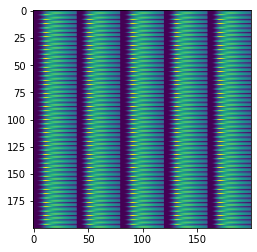

In [49]:
fig, (ax1) = plt.subplots(1, 1)
ax1.imshow(Cmetab_tmp)

## Simulate experiment using:
- the pulse sequence definition
- signal model
- mask as a phantom

In [ ]:
from typing import Tuple
class ExampleSimulation(cmrsim.analytic.AnalyticSimulation):
    def build(self, matrix_size: Tuple[int, int] = (80, 100),
              field_of_view: Tuple[float, float] = (0.25, 0.3)):
        n_kx, n_ky = matrix_size

        # Encoding definition / To enable result comparisons, the noise is set to 0 here
        encoding_module = cmrsim.analytic.encoding.EPI(field_of_view=field_of_view, sampling_matrix_size=matrix_size,
                                                       read_out_duration=0.4, blip_duration=0.01, k_space_segments=1,
                                                       absolute_noise_std=0.)
        # Signal module construction
        spinecho_module = cmrsim.analytic.contrast.SpinEcho(echo_time=50, repetition_time=10000, expand_repetitions=True)

        centered_times = tf.abs(encoding_module.get_sampling_times() - tf.reduce_max(encoding_module.get_sampling_times()) / 2)
        t2_star_module =  cmrsim.analytic.contrast.t2_star.StaticT2starDecay(centered_times, expand_repetitions=False)

        # Forward model composition
        forward_model = cmrsim.analytic.CompositeSignalModel(spinecho_module, t2_star_module)

        # Reconstruction
        recon_module = cmrsim.reconstruction.Cartesian2D(sample_matrix_size=(n_kx, n_ky), padding=None)
        return forward_model, encoding_module, recon_module

## Generate samples for spatial distribution score

In [20]:
# Cpyr_dyn, Clac_dyn, Cbic_dyn, Cala_dyn = [], [], [], []
save_root = Path(f'./C13data/val/')
# Cpyr_dyn = np.zeros((np.ma.size(Cpyr,0),X,X,np.ma.size(Cpyr,1)))
# Clac_dyn = np.zeros((np.ma.size(Cpyr,0),X,X,np.ma.size(Cpyr,1)))
# Cbic_dyn = np.zeros((np.ma.size(Cpyr,0),X,X,np.ma.size(Cpyr,1)))
# Cala_dyn = np.zeros((np.ma.size(Cpyr,0),X,X,np.ma.size(Cpyr,1)))

N = 1000
for i in tqdm(range(int(N))):
    rows, cols, _ = myoMask_ds.shape
    M = np.float32([[1,0,np.random.randint(-rows/4, rows/4)],[0,1,np.random.randint(-cols/4, cols/4)]])
    shifted_img = cv2.warpAffine(myoMask_ds[:,:,0], M, (cols, rows))
    
    # Randomly rotate the image
    angle = np.random.uniform(-180, 180)
    M = cv2.getRotationMatrix2D((cols/2,rows/2), angle, 1)
    rotated_img = cv2.warpAffine(shifted_img, M, (cols, rows))
    
    # Randomly scale the image
    scale = np.random.uniform(0.5, 2)
    M = cv2.getRotationMatrix2D((cols/2,rows/2), 0, scale)
    scaled_img = cv2.warpAffine(rotated_img, M, (cols, rows))
    
    fname = f'X{str(i)}'
    # hf = h5py.File(str(save_root / fname), 'w')
    np.save(str(save_root / fname) + '.npy', scaled_img.astype(np.float32)) 
    
#     Cpyr_dyn_tmp = np.multiply.outer(scaled_img,Cpyr[i][:])
#     Clac_dyn_tmp = np.multiply.outer(scaled_img,Clac[i][:])
#     Cbic_dyn_tmp = np.multiply.outer(scaled_img,Cbic[i][:])
#     Cala_dyn_tmp = np.multiply.outer(scaled_img,Cala[i][:])
    
#     metab_img1 = np.concatenate((Cpyr_dyn_tmp,Clac_dyn_tmp),axis=0)
#     metab_img2 = np.concatenate((Cala_dyn_tmp,Cbic_dyn_tmp),axis=0)
#     metab_img = np.concatenate((metab_img1,metab_img2),axis=1)
#     metab_stack_tmp = metab_img[:,:,0]
#     for n in range(1,3):
#         metab_stack_tmp = np.concatenate((metab_stack_tmp,metab_img[:,:,n]),axis=1)
#     metab_stack = metab_stack_tmp
#     for m in range(1,3):
#         metab_stack_tmp = metab_img[:,:,m*3]
#         for n in range(1,3):
#             metab_stack_tmp = np.concatenate((metab_stack_tmp,metab_img[:,:,m*3+n]),axis=1)
#         metab_stack = np.concatenate((metab_stack,metab_stack_tmp),axis=0)

    # Cpyr_dyn[i,:] = Cpyr_dyn_tmp
    # Clac_dyn[i,:] = Clac_dyn_tmp
    # Cbic_dyn[i,:] = Cbic_dyn_tmp
    # Cala_dyn[i,:] = Cala_dyn_tmp
    # fname = f'{str(i)}'
    # hf = h5py.File(str(save_root / fname), 'w')
    # np.save(str(save_root / fname) + '.npy', metab_stack.astype(np.float32))
    # np.save(str(save_root / fname) + '.npy', [Cpyr_dyn_tmp.astype(float),Clac_dyn_tmp.astype(float),Cbic_dyn_tmp.astype(float),Cala_dyn_tmp.astype(float)])
    # hf.create_dataset('data', data=metab_stack.astype(float))
    # hf.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

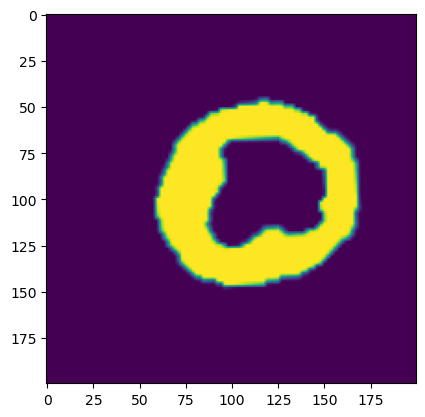

In [23]:
fig, (ax1) = plt.subplots(1, 1)
ax1.imshow(scaled_img)
plt.show()

## Load already reconstructed in vivo data

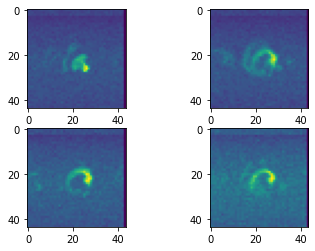

In [ ]:
mat = io.loadmat('../data/p12_03.mat')
metabolites = mat['c13img_slice']
metabolites = np.squeeze(metabolites)
data_pyr = np.pad(abs(metabolites[:,:,:,3]),((0,0),(0,1),(0,0)))
data_lac = np.pad(abs(metabolites[:,:,:,0]),((0,0),(0,1),(0,0)))
data_bic = np.pad(abs(metabolites[:,:,:,4]),((0,0),(0,1),(0,0)))
data_ala = np.pad(abs(metabolites[:,:,:,2]),((0,0),(0,1),(0,0)))
fig, (ax1) = plt.subplots(2, 2)
ax1[0,0].imshow(np.sum(abs(data_pyr),axis=2))
ax1[0,1].imshow(np.sum(abs(data_lac),axis=2))
ax1[1,0].imshow(np.sum(abs(data_bic),axis=2))
ax1[1,1].imshow(np.sum(abs(data_ala),axis=2))

## Save in vivo data to file for denoising recon
At this stage the prior is only used for denoising i.e., the recon input is the noisiy image which is fft2-ed

/scratch/vsomai/conda/lib/python3.8/site-packages/scipy/interpolate/fitpack2.py:1337: ComplexWarning: Casting complex values to real discards the imaginary part
  nx, tx, ny, ty, c, fp, ier = dfitpack.regrid_smth(x, y, z, xb, xe, yb,


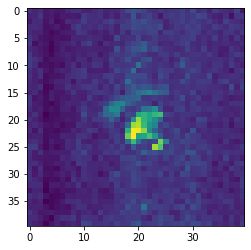

In [7]:
import copy, scipy.interpolate
metabolites2save = np.zeros((40,40,40,4),dtype=complex)
xi  = np.linspace(0,np.size(metabolites,0)-1,np.size(metabolites,0))
yi  = np.linspace(0,np.size(metabolites,1)-1,np.size(metabolites,1))
xiq = np.linspace(0,np.size(metabolites,0)-1,40)
yiq = np.linspace(0,np.size(metabolites,1)-1,40)
Xiq, Yiq = np.meshgrid(xiq,yiq)
interp_method = "splinef2d"
for i in range(40):
    metabolites2save[:,:,i,0] = scipy.interpolate.interpn((xi,yi),metabolites[:,:,i,3],(Xiq,Yiq), method=interp_method)
    metabolites2save[:,:,i,1] = scipy.interpolate.interpn((xi,yi),metabolites[:,:,i,0],(Xiq,Yiq), method=interp_method)
    metabolites2save[:,:,i,2] = scipy.interpolate.interpn((xi,yi),metabolites[:,:,i,4],(Xiq,Yiq), method=interp_method)
    metabolites2save[:,:,i,3] = scipy.interpolate.interpn((xi,yi),metabolites[:,:,i,2],(Xiq,Yiq), method=interp_method)
save_root = Path(f'./samples/single-coil/')
np.save(str(save_root / 'invivo_data') + '.npy', metabolites2save.astype(np.complex64))
fig, (ax1) = plt.subplots(1, 1)
ax1.imshow(np.squeeze(np.sum((np.abs(metabolites2save[:,:,:,0])),axis=-1)))

## Monitor training process i.e., check logged samples

In [16]:
sample = np.load('./workdir/fastmri_multicoil_knee_320/samples/iter_7/sample.np')
# sample = np.load('./C13data/val/X0.npy')

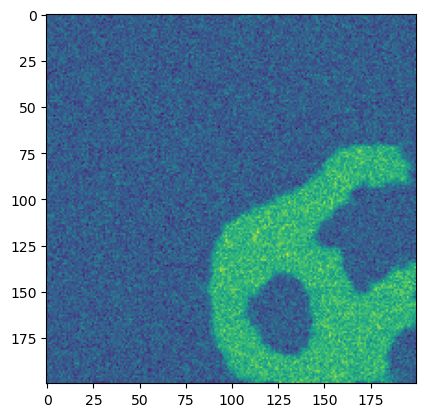

In [17]:
fig, (ax1) = plt.subplots(1, 1)
ax1.imshow(np.squeeze(sample))
plt.show()

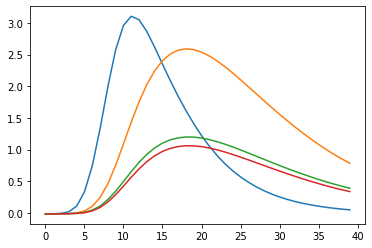

In [310]:
plt.plot(sample[0,0,0,:])
plt.plot(sample[0,0,1,:])
plt.plot(sample[0,0,2,:])
plt.plot(sample[0,0,3,:])

## Load recon result and compare it with the input

(40, 40, 40, 4)


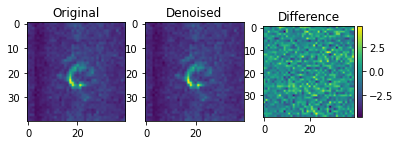

In [409]:
recon = np.load('./results/single-coil/recon/invivo_data.npy')
metNo = 3
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
print(np.shape(recon))
init_img = np.squeeze(np.sum((np.abs(metabolites2save[:,:,:,metNo])),axis=-1))
denoised = np.squeeze((np.sum(np.abs(recon[:,:,:,metNo]),axis=2)))
ax1.imshow(init_img)
ax1.set_title('Original')
ax2.imshow(denoised)
ax2.set_title('Denoised')
im3 = ax3.imshow((init_img - denoised))
ax3.set_title('Difference')
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im3, cax=cax, orientation='vertical')

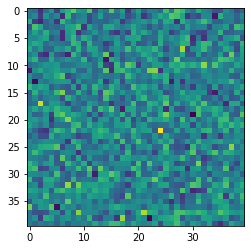

In [412]:
# from utils import fft2
sample_img = np.load('./results/single-coil/recon/invivo_data_kspace.npy')

fig, (ax1) = plt.subplots(1,1)
im1 = ax1.imshow(np.squeeze(np.real(np.fft.ifft2(sample_img[:,:,:,:]))))
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# divider = make_axes_locatable(ax1)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(im1, cax=cax, orientation='vertical')

In [1]:
from torch.utils.cpp_extension import CUDA_HOME
print(CUDA_HOME)

/usr/local/cuda
